In [194]:
import pandas as pd
import geopandas as gpd
import re
import nltk
from gensim.models.fasttext import FastText
from gensim.models import Word2Vec
from gensim.matutils import corpus2csc
from gensim.corpora import Dictionary
from gensim.models.keyedvectors import KeyedVectors

import pickle
import tempun
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
import unicodedata
from cltk.stops.grc import STOPS as stopwords


import ppmi_svd

In [2]:
GIST = gpd.read_parquet("../data/large_files/GIST_geocontexts.parquet")
len(GIST)

106898

# prepare data for lemmata filtering

In [16]:
try:
    with open("../data/large_files/morpheus_dict.json") as json_file:
        morpheus_dict = json.load(json_file)
# if not available:
except:
    # read it from a public folder on sciencedata
    publicfolder = "8fe7d59de1eafe5f8eaebc0044534606"
    morpheus_dict = json.loads(requests.get("https://sciencedata.dk/public/" + publicfolder + "/morpheus_dict.json").content)
    # save it locally for future usage
    with open("../data/large_files/morpheus_dict.json", "w") as outfile:
        json.dump(morpheus_dict, outfile)

In [20]:
len(morpheus_dict)

706506

In [23]:
len([el for el in morpheus_dict.items()])

706506

In [17]:
morpheus_lemmata_remove = []
for key in morpheus_dict.keys():
    values_list = morpheus_dict[key]
    for val_dict in values_list:
        if val_dict["l"] == key:
            if val_dict["p"][0] not in ["n", "a", "v"]:
                morpheus_lemmata_remove.append(key)

In [26]:
lemmata_remove = set(morpheus_lemmata_remove)
len(lemmata_remove)

1479

In [345]:
def normalize_encoding(string):
    return unicodedata.normalize("NFC", string)
stopwords = [normalize_encoding(s) for s in stopwords] + ["τίν", "γῶν", "τοῖρ", "κα"]

In [346]:
lemmata_remove.update(stopwords)
len(lemmata_remove)

1559

In [347]:
lemmata = ["Paul", "and", "Peter"]
remove = {"and", "or", "in"}

In [348]:
remove.intersection(lemmata)

{'and'}

In [349]:
set2.symmetric_difference(set1)

{'a', 'd'}

In [350]:
lemmata_remove

{'ἐντεῦθεν',
 'ὃδε',
 'μοναχῆ',
 'ζῆτα',
 'πάμπαν',
 'τούς',
 'διχῆ',
 'ποποποῖ',
 'πάνυ',
 'διότι',
 'πάραντα',
 'αἰβοῖ',
 'ἕως',
 'ἵνα',
 'ὀκτάκις',
 'ὡδί',
 'συνεκκαίδεκα',
 'ἑτέρως',
 'ἀγχοῦ',
 'σφαιρηδόν',
 'καταρχάς',
 'πώποτε',
 'οὗπερ',
 'αὖθις',
 'προπάροιθε',
 'πλήν',
 'οὐδαμῆ',
 'αὐτοβοεί',
 'τι',
 'δημοσίᾳ',
 'ἀρεσκόντως',
 'πενταχοῦ',
 'ὁσαχῆ',
 'διειλημμένως',
 'ἀκηρυκτεί',
 'καίπερ',
 'τὶς',
 'νῦν',
 'παρατεταγμένως',
 'ἐπίπλεως',
 'ποτέρως',
 'ὑπεράνω',
 'διάτριχα',
 'τόθεν',
 'ἕνεκα',
 'σύνεγγυς',
 'ἁμοῦ',
 'αὐτοσχεδόν',
 'ἐπάνωθεν',
 'θύρῃφι',
 'προσωτέρω',
 'φρενόθεν',
 'πάλιν',
 'ἐγκλιδόν',
 'ἐντυπάς',
 'πάλαι',
 'πέντε',
 'βῆ',
 'ἐπιπολύ',
 'ἄνευ',
 'ἄχρι',
 'ἄστυδε',
 'λίαν',
 'αὐτίκα',
 'καίτοι',
 'βοῖ',
 'κατά',
 'ἐπωμαδόν',
 'κατευθύ',
 'ἀπέξ',
 'ἐνθάδε',
 'συμφερόντως',
 'τετραχθά',
 'ὑποκάτω',
 'ὑπονομηδόν',
 'ὑψίκερως',
 'πλεοναχῶς',
 'ὑψόθεν',
 'καθέν',
 'ὑπερεκπερισσοῦ',
 'τοτέ',
 'βάδην',
 'ἐλεόν',
 'ἐννεακαίδεκα',
 'κατωκάρα',
 'ἁμαρτῆ',
 'βοτρυδόν',
 'σ

In [351]:
def filter_lemmata(lemmata_data):
    try:
        lemmata = lemmata_data["data"]
        to_remove = lemmata_remove.intersection(lemmata)
        lemmata_filtered = [l for l in lemmata if l not in to_remove]
        lemmata_filtered = [l for l in lemmata_filtered if len(l) > 1]
    except:
        lemmata_filtered = []
    return {"data" : lemmata_filtered}
GIST["lemmata_filtered"] = GIST["lemmata"].apply(filter_lemmata)

In [352]:
GIST.to_parquet("../data/large_files/GIST_geocontexts.parquet")

In [353]:
lemmata_data_test = {'data': ['Ζεύς', 'οὐ', 'ὁ', 'ἐπί', 'δραχμή', 'παρίημι', 'τε', 'ὁ', 'Ἀθήνη', 'χρεώστης', 'τοι', 'φίλος', 'χρῆμα', 'ε', 'ἔρομαι', 'ὁ', 'πρίν', 'ὁ', 'ἐν', 'Κριός', 'ὁ', 'τε', 'ἐπίσκοπος', 'αὐτός']}
filter_lemmata(lemmata_data_test)

{'data': ['Ζεύς',
  'δραχμή',
  'παρίημι',
  'Ἀθήνη',
  'χρεώστης',
  'φίλος',
  'χρῆμα',
  'ἔρομαι',
  'Κριός',
  'ἐπίσκοπος']}

In [354]:
GIST.sample(10)[["PHI_ID", "clean_text_interpretive_word", "lemmata", "raw_date", "not_before", "not_after", "random_dates","geometry"]]

,PHI_ID,clean_text_interpretive_word,lemmata,raw_date,not_before,not_after,random_dates,geometry
69253,299255,Aurelius Marianus,"{'data': ['ὁ', 'ὁ']}",2nd/3rd c. AD,101.0,300.0,"[161, 162, 239, 198, 140, 267, 166, 137, 230, ...",POINT (22.78730 45.51300)
81696,316642,ὁ δῆμος Λιμναῖον Ἀρχίου,"{'data': ['ὁ', 'δῆμος', 'διμναῖος', 'Ἄργος']}",2nd-1st c. BC,-200.0,-1.0,"[-13, -168, -103, -34, -149, -153, -86, -173, ...",POINT (27.18400 39.13175)
65485,294520,τοῦ σωθῆναι ἐκ τῶν ληιστῶν,"{'data': ['ποῦ', 'σῴζω', 'ἐκ', 'γῶν', 'ληιστύς']}",328/7 BC?,-328.0,-327.0,"[-327, -328, -328, -327, -327, -328, -327, -32...",POINT (23.72399 37.97275)
17110,166219,Ω 𐆠 Α Φλάβιος Καλανδίων Ἡρακλεώτης πολίτης φυλ...,"{'data': ['ὁ', 'ὁ', 'ὁ', 'ὄλβιος', 'καλαντίων'...",3rd/4th c. AD,201.0,400.0,"[384, 397, 216, 396, 342, 350, 312, 353, 328, ...",POINT (27.95297 40.97101)
34945,202155,ἡ οἰκουμένη εὐτύχει,"{'data': ['ὁ', 'οἰκουμένη', 'εὐτυχέω']}",7th c. AD,601.0,700.0,"[664, 691, 699, 696, 663, 624, 668, 653, 637, ...",POINT (24.94694 35.06272)
13140,146231,Βοιωτοὶ Ἀπόλλωνι Πτωΐοι ἀνέθιαν ἄρχοντος Βοιωτ...,"{'data': ['Βοιωτός', 'Ἀπόλλων', 'τοῖος', 'ἀνώπ...",ca. 290 BC,-295.0,-285.0,"[-288, -291, -294, -288, -287, -291, -293, -28...",POINT (23.34260 38.48450)
35760,207990,Ἀντίπατρος Ἀπολλοφάνεος Γαζαῖος,{'data': ['ζαζαῖος']},shortly after 300 BC,-299.0,NaN,"[-299, -299, -299, -299, -299, -299, -299, -29...",POINT (22.92234 39.34387)
95133,336850,☩ θεοτόκε βοήθι Βαανῃ ☩ κουβικουλαρίῳ καὶ βασι...,"{'data': ['ὁ', 'θερίζω', 'βοάω', 'λαῖνα', 'ὁ',...",ca. 570-625 AD,564.0,631.0,"[597, 624, 595, 613, 579, 567, 584, 588, 593, ...",POINT (12.48617 41.89174)
3218,28577,παρέδοˉκε ℎορμιάδας Φιλίσκος,"{'data': ['παράδοσις', 'ὅρμικας', 'φιλίσκος']}",6th/5th c. BC,-600.0,-401.0,"[-465, -534, -428, -404, -441, -547, -574, -50...",POINT (23.16016 37.63346)
32641,199278,χ ε Θ Ο νυ π β α δ μ ω κ,"{'data': ['ε', 'ὁ', 'ὁ', 'π', 'α', 'δ', 'μ', '...",2nd c. BC,-200.0,-101.0,"[-135, -190, -106, -142, -181, -113, -163, -13...",POINT (24.92598 34.93393)


In [355]:
sum(GIST["polis?"])

70503

In [356]:
GIST_lemmata_merged = [[l for l in inscr_lem["data"]] for inscr_lem in GIST["lemmata_filtered"].tolist()]
GIST_lemmata_merged = [l for i in GIST_lemmata_merged for l in i]
len(GIST_lemmata_merged)

1431651

In [357]:
freqs_tups = nltk.FreqDist(GIST_lemmata_merged).most_common()
freqs_tups[:200]

[('δῆμος', 15428),
 ('θεός', 13934),
 ('πᾶς', 13819),
 ('ἔτος', 9493),
 ('βουλή', 9301),
 ('ἄρχων', 9189),
 ('ἱερός', 8985),
 ('ἔχω', 7008),
 ('βράχoς', 6926),
 ('μείς', 6881),
 ('ἀγαθός', 6691),
 ('υἱός', 5728),
 ('ἀνατίθημι', 5031),
 ('ἀνήρ', 4986),
 ('λωτοφάγoi', 4969),
 ('δραχμή', 4856),
 ('βασιλεύς', 4667),
 ('στρατιώτης', 4665),
 ('δίδωμι', 4618),
 ('ἱερεύς', 4552),
 ('τιμή', 4484),
 ('Ἀπολλωνία', 4478),
 ('χαίρω', 4393),
 ('γυνή', 4332),
 ('παῖς', 4290),
 ('γίγνομαι', 4280),
 ('στέφανος', 4280),
 ('Ζεύς', 4079),
 ('ποιέω', 4033),
 ('χάρις', 3951),
 ('νόμος', 3865),
 ('ψήφισμα', 3762),
 ('Δελφοί', 3710),
 ('δοκέω', 3586),
 ('πατήρ', 3525),
 ('ὁλκή', 3510),
 ('λέγω', 3488),
 ('καλός', 3346),
 ('Μᾶρκος', 3328),
 ('πολύς', 3313),
 ('κοινός', 3308),
 ('Ἀσκληπιός', 3131),
 ('εὐεργέτης', 3077),
 ('μέλει', 3070),
 ('Ἀπόλλων', 3070),
 ('Ἀθῆναι', 3003),
 ('πράσσω', 2954),
 ('χράω', 2889),
 ('Σεβαστός', 2889),
 ('δέω', 2862),
 ('ἐπειδή', 2858),
 ('στήλη', 2722),
 ('ὅσος', 2716),
 ('ὁράω', 

In [358]:
publicfolder = "8fe7d59de1eafe5f8eaebc0044534606"
morpheus_by_lemma = json.loads(requests.get("https://sciencedata.dk/public/" + publicfolder + "/morpheus_by_lemma.json").content)

In [359]:
freqs_tups_translated = []
for tup in freqs_tups:
    try:
        transl = morpheus_by_lemma[tup[0]][0]["s"]
    except:
        transl = ""
    freqs_tups_translated.append((tup[0], tup[1], transl))

In [360]:
freqs_tups_translated[:200]

[('δῆμος', 15428, 'a country-district, country, land'),
 ('θεός', 13934, 'God'),
 ('πᾶς', 13819, 'all, the whole'),
 ('ἔτος', 9493, 'a year'),
 ('βουλή', 9301, 'will, determination'),
 ('ἄρχων', 9189, 'a ruler, commander, chief, captain'),
 ('ἱερός', 8985, 'super-human, mighty, divine, wonderful'),
 ('ἔχω', 7008, 'to have'),
 ('βράχoς', 6926, ''),
 ('μείς', 6881, 'a month'),
 ('ἀγαθός', 6691, 'good'),
 ('υἱός', 5728, 'A son'),
 ('ἀνατίθημι', 5031, 'to lay upon'),
 ('ἀνήρ', 4986, 'a man'),
 ('λωτοφάγoi', 4969, ''),
 ('δραχμή', 4856, 'a handful'),
 ('βασιλεύς', 4667, 'a king, chief'),
 ('στρατιώτης', 4665, 'a citizen bound to military service;'),
 ('δίδωμι', 4618, 'to give'),
 ('ἱερεύς', 4552, 'a priest, sacrificer'),
 ('τιμή', 4484, 'that which is paid in token of worth'),
 ('Ἀπολλωνία', 4478, ''),
 ('χαίρω', 4393, 'to rejoice, be glad, be delighted'),
 ('γυνή', 4332, 'a woman'),
 ('παῖς', 4290, 'a child'),
 ('γίγνομαι', 4280, 'gi-geno'),
 ('στέφανος', 4280, 'that which surrounds'),
 ('

In [361]:
pd.DataFrame(freqs_tups[:5000]).to_csv("../data/freq_tups.csv")

In [362]:
pickle.dump(freqs_tups, open("../data/freqs_tups.pickle", "wb"))

In [363]:
match_pattern = "(κατα|ὑπό|ἐκ|ἀ|ἄ|ἀντί|^)δ[ι|ί]κ(α|ά|ο|ό|ί|έ|η)(.+)?"
dik_words = [word for word in GIST_lemmata_merged if re.search(match_pattern, word)]
dik_words_df = pd.DataFrame(nltk.FreqDist(dik_words).most_common(), columns=["lemma", "count"])
dik_words_df.head(5)

,lemma,count
0,δικαίως,1302
1,δίκαιος,685
2,δικαστής,504
3,δικαιοσύνη,458
4,δίκη,410


# Singular words explorations

In [183]:
religion = ["θεός", "Ζεύς", "εὐσέβεια", 'ἱερεύς', "θυσία"]
religion_2 = ["ἱερόν", "ἱερός", "δῖος", "θυσία", "ἅγιος" ,"Διονύσιος", "Ἀπόλλων", "Ἡρακλέης",  "Ἀθήνη", "Ἄρτεμις", "εὐσεβής"]

morality = ["ἀγαθός", "ἀρετή", "δικαίως", "δίκαιος", "τιμή", "φιλία", "φίλος"]
morality_2 = ["τιμάω", "εἰρήνη", "δικαιοσύνη", ]

word_list = religion + religion_2 + morality + morality_2

In [190]:
religion_final = ["θεός", "Ζεύς", "εὐσεβής", 'ἱερός']
morality_final = ["ἀγαθός", "ἀρετή", "δικαίως", "φίλος"]

In [122]:
len(word_list)

24

In [75]:
for word in word_list:
    print(word, GIST_lemmata_merged.count(word))

θεός 13934
Ζεύς 4079
εὐσέβεια 191
ἱερεύς 4552
θυσία 874
ἱερόν 328
ἱερός 8985
δῖος 2
θυσία 874
Διονύσιος 1072
Ἀπόλλων 3070
Ἀπολλώνιος 1291
Ἡρακλέης 1716
Ἀθήνη 1799
Ἄρτεμις 1475
εὐσεβής 2362
ἀγαθός 6691
ἀρετή 2404
δικαίως 1302
δίκαιος 685
τιμή 4484
τιμάω 1593
εἰρήνη 1039
δικαιοσύνη 458


In [77]:
time_blocks = [[n, n+100] for n in range(-850, 410, 10)]
time_blocks[:3]

[[-850, -750], [-840, -740], [-830, -730]]

In [79]:
def sim_data_by_function(df, n_sims, time_blocks, function, args_dict=None, random_dates_column="random_dates"):
    complete_sim_data = []
    for n in range(n_sims):
        sim = df[random_dates_column].apply(lambda x: tempun.get_date_from_randoms(x, n))
        sim_data = []
        if isinstance(time_blocks[0],
                      int):  # if first entry of timeblocks is an integer it means that it is actually not a timeblock, but only the starting date of the first timeblock
            time_blocks = tempun.get_timeblocks(time_blocks[0], time_blocks[1], time_blocks[2])
        for tb in time_blocks:
            mask = sim.between(tb[0], tb[1])
            df_tb = df[mask]
            function_output = function(df_tb, args_dict)
            sim_data.append((tb, function_output))
        complete_sim_data.append(sim_data)
    return complete_sim_data

def get_word_frequency(timeblock_df, args_dict):
    word = args_dict["word"]
    all_lemmata = [[l for l in inscr_lem["data"]] for inscr_lem in timeblock_df["lemmata_filtered"].tolist()]
    all_lemmata = [l for i in all_lemmata for l in i]
    all_lemmata_N = len(all_lemmata)
    word_N = all_lemmata.count(word)
    word_freq = word_N / all_lemmata_N
    return np.round(word_freq, 5)

In [80]:
word_freq = sim_data_by_function(GIST, 10, time_blocks=time_blocks, function=get_word_frequency, args_dict={"word" : "θεός"})

[[<matplotlib.patches.Polygon at 0x2e368ffa0>],

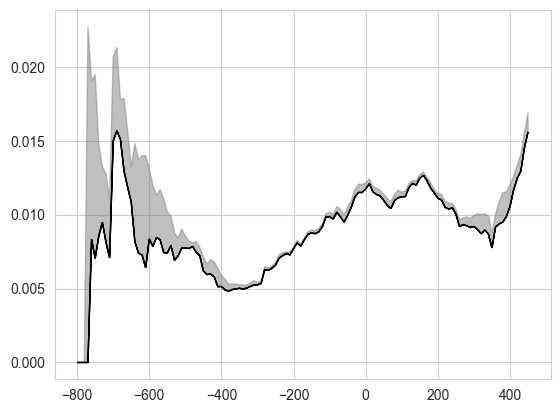

In [81]:
tempun.plot_timeblocks_data(word_freq)

In [102]:
%%time
# sim_data_freq = {}
#for word in word_list:
#    print(word)
#    word_freq = sim_data_by_function(GIST, 100, time_blocks=time_blocks, function=get_word_frequency, args_dict={"word": word})
    #sim_data_freq[word] = word_freq

CPU times: user 10 µs, sys: 6 µs, total: 16 µs
Wall time: 26 µs


In [186]:
#pickle.dump(sim_data_freq, open("../data/large_files/sim_data_freq.pickle", "wb"))

In [187]:
#sim_data_freq = pickle.load(open("../data/large_files/sim_data_freq.pickle", "rb"))

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_60541/213055883.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[8,2].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,500,100)], rotation=90)


Text(-0.02, 0.5, 'word frequency')

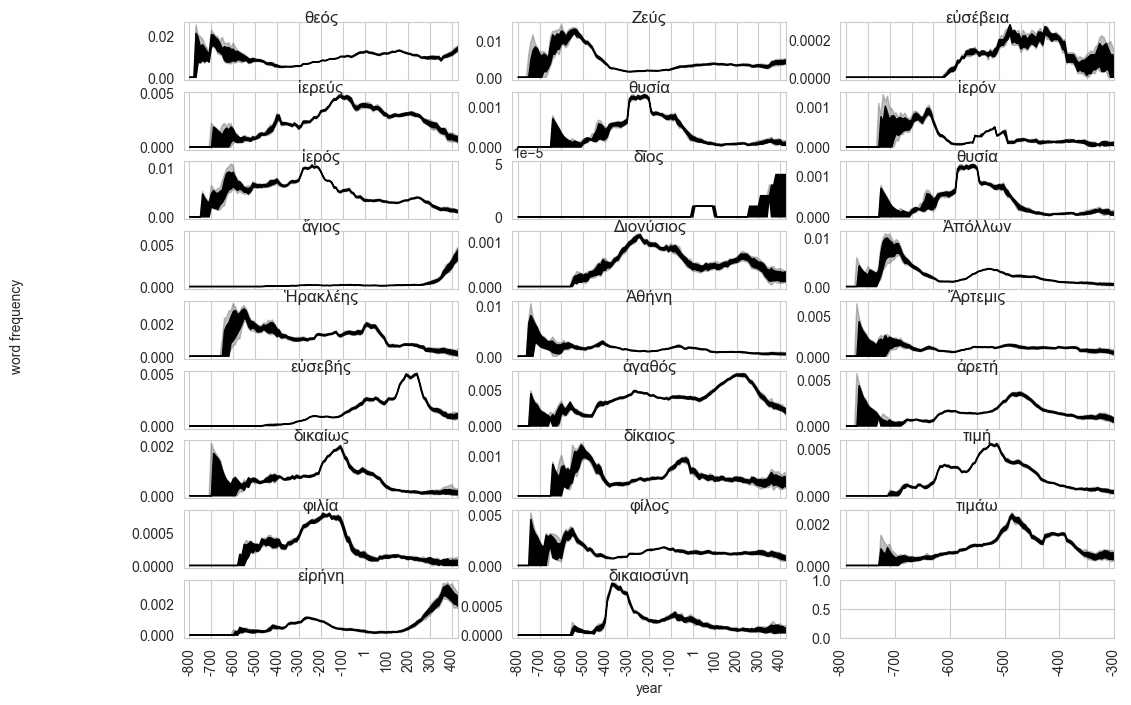

In [189]:
fig, axs = plt.subplots(9,3, figsize=(12, 8))#, tight_layout=True)

for word, ax in zip(word_list, axs.ravel()):
    tempun.plot_timeblocks_data(sim_data_freq[word], ax=ax)
    ax.set_xticklabels([])
    ax.grid(False, axis="y")
    ax.set_title(word, pad=-0.3)
    ax.set_xticks([el+1 if el==0 else el for el in range(-800,500,100)])
    ax.set_xlim(-825,425)
axs[8,0].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,500,100)], rotation=90)

axs[8,1].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,500,100)], rotation=90)

axs[8,2].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,500,100)], rotation=90)

ax.set_xlabel("year")

fig.text(-0.02, 0.5, 'word frequency', va='center', rotation='vertical')

Text(-0.02, 0.5, 'word frequency')

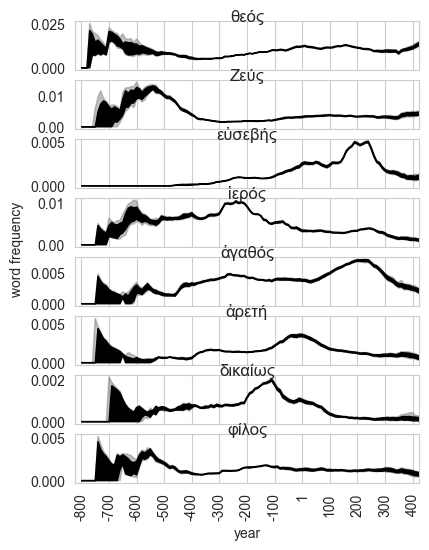

In [191]:
fig, axs = plt.subplots(8,1, figsize=(4.45, 6))#, tight_layout=True)

for word, ax in zip(religion_final + morality_final, axs.ravel()):
    tempun.plot_timeblocks_data(sim_data_freq[word], ax=ax)
    ax.set_xticklabels([])
    ax.grid(False, axis="y")
    ax.set_title(word, pad=-0.3)
    ax.set_xticks([el+1 if el==0 else el for el in range(-800,500,100)])
    ax.set_xlim(-825,425)
ax.set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,500,100)], rotation=90)

ax.set_xlabel("year")

fig.text(-0.02, 0.5, 'word frequency', va='center', rotation='vertical')

# Building ngrams data

In [130]:
def get_ngrams(lemmata_data):
    lemmata_list = lemmata_data["data"]
    ngrams = []
    try:
        bigrams = list(nltk.ngrams(lemmata_list, 2))
        trigrams = list(nltk.ngrams(lemmata_list, 3, pad_right=True, pad_left=True))
        fivegrams = list(nltk.ngrams(lemmata_list, 5, pad_right=True, pad_left=True))
        ngrams_merged = bigrams + trigrams + fivegrams
        ngrams_merged = [[i for i in ngram if i is not None] for ngram in ngrams_merged]
        ngrams_merged = [ngram for ngram in ngrams_merged if (len(ngram) > 1)]
    except:
        ngrams_merged = [[]]
    return ngrams_merged


In [131]:
print(get_ngrams({"data" : ["lemma1", "lemma2", "lemma3", "lemma4", "lemma5", "lemma6"]}))

[['lemma1', 'lemma2'], ['lemma2', 'lemma3'], ['lemma3', 'lemma4'], ['lemma4', 'lemma5'], ['lemma5', 'lemma6'], ['lemma1', 'lemma2'], ['lemma1', 'lemma2', 'lemma3'], ['lemma2', 'lemma3', 'lemma4'], ['lemma3', 'lemma4', 'lemma5'], ['lemma4', 'lemma5', 'lemma6'], ['lemma5', 'lemma6'], ['lemma1', 'lemma2'], ['lemma1', 'lemma2', 'lemma3'], ['lemma1', 'lemma2', 'lemma3', 'lemma4'], ['lemma1', 'lemma2', 'lemma3', 'lemma4', 'lemma5'], ['lemma2', 'lemma3', 'lemma4', 'lemma5', 'lemma6'], ['lemma3', 'lemma4', 'lemma5', 'lemma6'], ['lemma4', 'lemma5', 'lemma6'], ['lemma5', 'lemma6']]


In [132]:
%%time
GIST["ngrams"] = GIST["lemmata_filtered"].apply(get_ngrams)

CPU times: user 5.23 s, sys: 1.06 s, total: 6.29 s
Wall time: 7.08 s


In [133]:
GIST.head(5)

,PHI_ID,reference,metadata,lines,text_raw,text_iphi,clean_text_conservative,clean_text_interpretive_word,lemmata,raw_date,...,random_dates,geotemporal?,greece?,name,polis_geo,polis_dist,polis?,duration,lemmata_filtered,ngrams
0,1,IG I³\n1,Att. — Ath.: Akr. — stoich. 35 — c. 510-500 a....,12.0,ἔδοχσεν το͂ι δέμοι· τ̣[ὸς ἐ Σ]αλαμ̣[ῖνι κλερόχ...,εδοχσεν τοι δεμοι τ[ος ε σ]αλαμ[ινι κλεροχ]ος ...,ἔδοχσεν το͂ι δέμοι ταλαμος οἰκε͂ν ἐᾶ Σαλαμῖνι ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,"{'data': ['ἔδοχσεν', 'το͂ι', 'δέμοι', 'τὸς', '...",c. 510-500 a.,...,"[-501, -505, -509, -503, -510, -506, -504, -50...",True,True,361-Athenai,"[23.7278, 37.9778]",653.43,True,13.0,"{'data': ['ἔδοχσεν', 'το͂ι', 'δέμοι', 'τὸς', '...","[[ἔδοχσεν, το͂ι], [το͂ι, δέμοι], [δέμοι, τὸς],..."
1,4,IG I³\n4,Att. — stoich. 38 — 485/4 a.,56.0,[․․․․․․․․․․․․․․․․․․38․․․․․․․․․․․․․․․․․․]\n[․․․...,[--------------------------------------] [----...,δέ τις αν ἒ φρορὰν μ ντέκοντα δχμὰς τ ας ℎες π...,ἐὰν δέ τις αν ἒ φρορὰν μὲ πεντέκοντα δραχμὰς τ...,"{'data': ['ἐάν', 'τις', 'ἐν', 'ἒ', 'φρουρά', '...",485/4 a.,...,"[-484, -485, -484, -484, -484, -485, -485, -48...",True,True,361-Athenai,"[23.7278, 37.9778]",653.43,True,2.0,"{'data': ['φρουρά', 'δραχμή', 'πρᾶξις', 'ἄρχων...","[[φρουρά, δραχμή], [δραχμή, πρᾶξις], [πρᾶξις, ..."
2,5,IG I³\n5,Att. — c. 500 a.,6.0,[ἔδοχσε]ν [⋮ τε͂ι βολε͂ι] ⋮ καὶ [τ]ο͂ι δέμοι ⋮...,[εδοχσε]ν [ τει βολει] και [τ]οι δεμοι οτε παρ...,ν καὶ ο͂ι δέμοι ℎότε Παραιβάτες λεια θν τὸς ℎι...,ἔδοχσεν τε͂ι βολε͂ι καὶ το͂ι δέμοι ℎότε Παραιβ...,"{'data': ['δοκέω', 'βουλή', 'καὶ', 'ὁ', 'δῆμος...",c. 500 a.,...,"[-496, -502, -504, -498, -501, -503, -499, -50...",True,True,362-Eleusis,"[23.5423, 38.0394]",530.31,True,11.0,"{'data': ['δοκέω', 'βουλή', 'δῆμος', 'παραβάτη...","[[δοκέω, βουλή], [βουλή, δῆμος], [δῆμος, παραβ..."
3,6,IG I³\n6,Att. — stoich. 23/11 — ante 460 a.,160.0,— — — — — — — — — — — — —\n[․․․․․․15․․․․․․․] δ...,------------- [---------------] δραχμεισ[ι ---...,δραχμε͂ιστες τὸς ιο μενος δεμο το͂ν πόλεο οκε͂...,δραχμε͂ισι τες τὸς ιο μενος δεμο το͂ν πόλεον δ...,"{'data': ['δραχμός', 'τε', 'τὶς', 'μόνος', 'δῆ...",ante 460 a.,...,"[-461, -461, -461, -461, -461, -461, -461, -46...",True,True,362-Eleusis,"[23.5423, 38.0394]",530.31,True,NaN,"{'data': ['δραχμός', 'μόνος', 'δῆμος', 'παλέω'...","[[δραχμός, μόνος], [μόνος, δῆμος], [δῆμος, παλ..."
4,11,IG I³\n11,Att. — stoich. 48 — ante med. s. V a.,22.0,[χσυμμαχία καὶ ℎόρ]κ̣ο̣[ς] Ἀ̣[θ]ε̣ν̣α̣[ίον κα]...,[χσυμμαχια και ορ]κο[ς] α[θ]ενα[ιον κα]ι εγεστ...,κο Ἀεναὶ Ἐγεσταί ο͂ι ἐπρυτάνευε οΙ ον ἐ͂ρχε Ἀ...,χσυμμαχία καὶ ℎόρκος Ἀθεναίον καὶ Ἐγεσταίον ἔδ...,"{'data': ['συμμαχία', 'καὶ', 'ὅρκος', 'φθινάς'...",ante med. s. V a.,...,"[-456, -456, -456, -456, -456, -456, -456, -45...",True,True,361-Athenai,"[23.7278, 37.9778]",653.43,True,NaN,"{'data': ['συμμαχία', 'ὅρκος', 'φθινάς', 'Ἐγεσ...","[[συμμαχία, ὅρκος], [ὅρκος, φθινάς], [φθινάς, ..."


In [134]:
%%time
f = open("../data/large_files/corpus_ngrams.txt", "w", encoding="utf-8")
line = 0
ids_lines = {}
for n in range(len(GIST)):
    id = str(GIST.iloc[n]["PHI_ID"])
    try:
        ngrams = [" ".join(ngram) for ngram in GIST.iloc[n]["ngrams"]]
        f.writelines("\n".join(ngrams)+"\n")
        ids_lines[id] = (line, line+len(ngrams))
        line += len(ngrams)
    except:
        print(id)

CPU times: user 16.3 s, sys: 631 ms, total: 16.9 s
Wall time: 18 s


In [135]:
pickle.dump(ids_lines, open("../data/ids_lines.pickle", "wb"))

In [136]:
class NgramCorpus:
    def __iter__(self):
        with open("../data/large_files/corpus_ngrams.txt", "r") as f:
            lines = f.readlines()
            for phi_id in ids_list:
                for line in lines[ids_lines[phi_id][0] : ids_lines[phi_id][1]]:
                    yield line.split()

In [137]:
ids_list = ["1","4","15","17"]

In [138]:
corpus = NgramCorpus()

In [139]:
len([doc for doc in corpus])

817

In [140]:
ids_list = GIST[GIST["random_dates"].apply(lambda x: -500 < x[0] < -401)]["PHI_ID"].astype("str").tolist()
len(ids_list)

6707

In [141]:
corpus = NgramCorpus()

In [142]:
corpus_len = len([doc for doc in corpus])
corpus_len

116225

In [143]:
N_tokens = sum([el[1] for el in freqs_tups])
N_tokens

1530197

In [144]:
N_types = len(freqs_tups)
N_types

45881

# Developing/testing PPMI-SVD model

In [320]:
N_types_covered = 2000
N_tokens_covered = sum([el[1] for el in freqs_tups[:N_types_covered]])
N_tokens_covered / N_tokens

0.7417450171448513

In [321]:
N_types_covered = 2000
vocab = [tup[0] for tup in freqs_tups[:N_types_covered]]
dictionary = Dictionary([vocab])

In [322]:
dictionary.doc2bow(["θεός", "θεός","Ζεύς", "nonexistent", "εὐσέβεια", 'ἱερεύς', "θυσία"])

[(70, 1), (580, 1), (627, 2), (641, 1), (1868, 1)]

In [324]:
dictionary[627]

'θεός'

In [325]:
len(dictionary)

2000

In [327]:
class NgramCorpusBows:
    def __iter__(self):
        with open("../data/large_files/corpus_ngrams.txt", "r") as f:
            lines = f.readlines()
            for phi_id in ids_list:
                for line in lines[ids_lines[phi_id][0] : ids_lines[phi_id][1]]:
                    bow = dictionary.doc2bow(line.split())
                    yield bow

In [173]:
ids_list = GIST[GIST["random_dates"].apply(lambda x: -500 < x[0] < -401)]["PHI_ID"].astype("str").tolist()
len(ids_list)

6707

In [176]:
corpus = NgramCorpusBows()

In [180]:
cooc, vocabulary, pmi_matrix, word_vectors_df, pmi_svd_cos = ppmi_svd.from_bows_to_embeddings(corpus, dictionary)

In [184]:
word_vectors_df

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
Eπικυδής,0.071822,0.027417,0.018761,-0.020267,-0.011901,-0.013834,-0.001161,0.023684,0.080448,-0.059726,...,-0.043830,-0.080712,-0.048065,-0.013449,0.096584,-0.035397,-0.068760,0.023778,0.098145,-0.027721
Nησαῖος,0.110407,0.040922,0.049618,-0.009237,-0.004626,-0.092886,-0.029322,-0.031358,0.054895,-0.076808,...,-0.043137,-0.112853,-0.045576,-0.030972,0.119049,-0.022573,-0.112848,0.051499,0.071619,0.038090
Αἰακίδαι,0.279980,-0.069847,-0.091386,-0.183616,0.011361,-0.057459,-0.012027,0.142265,0.009433,0.062644,...,0.018739,-0.036810,0.032169,0.168597,-0.068915,0.044800,-0.085225,-0.088076,-0.009522,-0.003085
Αἰακός,0.446331,0.168221,-0.034451,0.004203,-0.323604,0.061287,-0.112263,0.083774,0.312660,-0.215238,...,-0.124709,-0.084688,-0.011506,-0.041363,0.059547,-0.170203,-0.028620,0.049906,-0.056551,0.119878
Αἰγήλιος,0.575679,0.389231,0.078726,0.504647,0.036794,-0.048610,-0.247118,0.108564,0.226982,-0.087656,...,0.274794,-0.397868,0.079351,-0.100219,0.149952,-0.512497,-0.023866,0.101846,0.128743,-0.085604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ῥοῦφος,0.939535,0.396819,-0.270942,0.411205,-0.203156,0.492220,-0.251058,0.388045,0.279500,-0.365368,...,-0.058395,-0.117483,-0.160800,0.073510,0.011992,0.025063,0.067175,-0.024076,-0.087565,0.018650
Ῥωμαῖος,1.613467,0.284235,-0.248774,0.776974,0.671817,-0.065087,-0.090589,-0.436719,-0.011797,0.071347,...,0.387592,0.025712,0.073687,0.268949,0.143477,-0.006202,0.369637,0.315410,0.429818,-0.287570
Ῥόδη,1.486378,-0.572857,-0.547181,-0.017236,0.251952,0.053045,-0.218287,-0.131465,0.434852,0.434089,...,-0.068494,0.236291,-0.109267,-0.200945,0.292850,0.244746,0.164473,-0.317827,-0.134765,-0.534216
Ῥόδος,1.828942,-0.150905,-0.545217,-0.076020,-0.412989,0.202496,0.500597,0.364426,0.656951,0.045951,...,0.274317,-0.233393,0.191104,-0.034609,0.104496,-0.190139,0.186093,-0.044118,-0.381240,0.052922


In [304]:
pmi_svd_cos["θεός"].sort_values(ascending=False)

θεός          1.000000
τίν           0.446479
πᾶς           0.400295
τοῖρ          0.399787
γῶν           0.375273
                ...   
παντοδαπός   -0.023364
Σοῦσα        -0.026869
δοξάζω       -0.028543
περίπου      -0.031850
παιδεύω      -0.031850
Name: θεός, Length: 5000, dtype: float64

In [242]:
np.zeros(5000).shap

(5000,)

In [286]:
ok_positions = [n for n, el in enumerate(np.array(cooc.sum(axis=0))[0]) if el>0]

In [289]:
svd_matrix[ok_positions]

array([[ 0.07182153,  0.02741733,  0.01876102, ...,  0.02377781,
         0.09814454, -0.02772136],
       [ 0.11040709,  0.04092238,  0.04961831, ...,  0.05149943,
         0.07161879,  0.03809021],
       [ 0.27998048, -0.06984748, -0.09138583, ..., -0.08807603,
        -0.00952155, -0.00308531],
       ...,
       [ 1.48637807, -0.57285691, -0.54718079, ..., -0.31782679,
        -0.1347652 , -0.53421551],
       [ 1.82894232, -0.15090494, -0.54521717, ..., -0.044118  ,
        -0.3812399 ,  0.0529221 ],
       [ 1.55825677,  0.23237681, -0.47905411, ..., -0.49005275,
         0.04068009, -0.09963963]])

In [291]:
np.array(vocabulary)[ok_positions]

array(['Eπικυδής', 'Nησαῖος', 'Αἰακίδαι', ..., 'Ῥόδη', 'Ῥόδος', 'Ῥώμη'],
      dtype='<U15')

In [279]:
word_vectors_df.iloc[12]

0      5.501105e-31
1      1.234664e-20
2     -1.384722e-20
3     -1.047347e-20
4      8.385330e-20
           ...     
145   -1.305039e-16
146    3.714566e-17
147   -3.108038e-17
148   -2.541193e-16
149   -8.693694e-17
Name: Αἰνησίδημος, Length: 150, dtype: float64

In [275]:
vocabulary

TypeError: list indices must be integers or slices, not list

In [192]:
svd_matrix = ppmi_svd.svd_reduction(pmi_matrix)

In [310]:
keyedvectors = KeyedVectors(150)

In [311]:
keyedvectors.add_vectors(vocabulary, svd_matrix)

In [312]:
#keyedvectors.add_vectors(np.array(vocabulary)[ok_positions], svd_matrix[ok_positions])

In [313]:
religion_final

['θεός', 'Ζεύς', 'εὐσεβής', 'ἱερός']

In [316]:
keyedvectors.most_similar("θεός", topn=200)

[('κόριψ', inf),
 ('οἰκτρός', inf),
 ('ἀπελευθέρωσις', inf),
 ('ξενοφωνία', inf),
 ('ξένιος', inf),
 ('νικόβουλος', inf),
 ('μύρια', inf),
 ('Πριήνη', inf),
 ('ἀποφορά', inf),
 ('μόλυβδος', inf),
 ('μουσοτραφής', inf),
 ('μισθωτός', inf),
 ('μηλιάδες', inf),
 ('μεταπέμπω', inf),
 ('μετέρχομαι', inf),
 ('μελισσόφονος', inf),
 ('μείλια', inf),
 ('ἀρχιέρεια', inf),
 ('ἁρμός', inf),
 ('ἁρμόττω', inf),
 ('Καμαριναῖος', inf),
 ('μείζων', inf),
 ('ἀπαιτέω', inf),
 ('μαζαγόας', inf),
 ('Πλατέα', inf),
 ('ἀνολισθάνω', inf),
 ('παλαιστός', inf),
 ('ἀλείφω', inf),
 ('Κολοσσαί', inf),
 ('ἀλεξάνδρειος', inf),
 ('ἀμφίεσις', inf),
 ('πίσυνος', inf),
 ('ἀνάβασις', inf),
 ('πέπων', inf),
 ('ἀνάσφορον', inf),
 ('πέλεκρα', inf),
 ('πάροικος', inf),
 ('ἀναγνώστης', inf),
 ('πάππος', inf),
 ('ἀναπόκριτος', inf),
 ('ἀναστησείω', inf),
 ('Περσεῖδαι', inf),
 ('οὔριος', inf),
 ('ἀναφαίνω', inf),
 ('Πλακία', inf),
 ('ἀνδρώνιον', inf),
 ('ἀνθρωπίζω', inf),
 ('ἀξίωμα', inf),
 ('μέσφι', inf),
 ('μάχαιρα', inf),
 (

# Testing word2vec and FastText

In [174]:
class NgramCorpus:
    def __iter__(self):
        with open("../data/large_files/corpus_ngrams.txt", "r") as f:
            lines = f.readlines()
            for phi_id in ids_list:
                for line in lines[ids_lines[phi_id][0] : ids_lines[phi_id][1]]:
                    yield line.split()

In [168]:
ids_list = GIST[GIST["random_dates"].apply(lambda x: -500 < x[0] < -401)]["PHI_ID"].astype("str").tolist()
len(ids_list)

6707

In [169]:
corpus = NgramCorpus()

In [146]:
model = Word2Vec(vector_size=150, window=3, negative=5, ns_exponent=1, sg=0, epochs=10, workers=8)

In [147]:
model.build_vocab_from_freq(word_freq=dict(freqs_tups[:N_types_covered]))

In [148]:
%%time
model.train(corpus, total_examples=corpus_len, epochs=model.epochs)

CPU times: user 9.96 s, sys: 1.42 s, total: 11.4 s
Wall time: 9.47 s


(2707656, 3598520)

In [149]:
model.wv.most_similar("θεός")

[('πρᾶξις', 0.5145177841186523),
 ('Ἱππίας', 0.4894202649593353),
 ('κραιπνός', 0.48578259348869324),
 ('οὐδός', 0.47578614950180054),
 ('δεσπότης', 0.4744507074356079),
 ('αὐτοκράτωρ', 0.4731665849685669),
 ('ἔξεστι', 0.47039496898651123),
 ('νειότατον', 0.46926066279411316),
 ('γλυκυπότης', 0.46815016865730286),
 ('θέατρον', 0.46508654952049255)]

In [150]:
model = FastText(vector_size=150, window=3, negative=5, ns_exponent=1, sg=0, epochs=5, workers=8, min_n=4)
model.build_vocab_from_freq(word_freq=dict(freqs_tups[:N_types_covered]))
model.train(corpus, total_examples=corpus_len, epochs=model.epochs)

(1353814, 1799260)

In [151]:
model.wv.most_similar("θεός")

[('πυκνός', 0.9343011379241943),
 ('ἱκανός', 0.926031231880188),
 ('ἀκριβής', 0.925027072429657),
 ('υἱωνός', 0.9206536412239075),
 ('εὐσεβέω', 0.918022632598877),
 ('διατονικός', 0.9179865121841431),
 ('θεοσεβής', 0.9157906174659729),
 ('οὐετερανός', 0.9151716828346252),
 ('μεγιστάν', 0.9140370488166809),
 ('ἔρουα', 0.9126608967781067)]

# Developing century excluding models with FastText

In [77]:
for cent in range(-8, 8):
    if cent < 0:
        cent_start, cent_end = cent * 100, cent * 100 + 99
    else:
        cent_start, cent_end = cent * 100 + 1, cent * 100 + 100
    subset = GIST[GIST["random_dates"].apply(lambda x: cent_start < x[0] < cent_end)]
    print(cent_start, cent_end, (len(subset)))


-800 -701 63
-700 -601 382
-600 -501 2623
-500 -401 6604
-400 -301 9668
-300 -201 14232
-200 -101 13448
-100 -1 8443
1 100 9893
101 200 15986
201 300 11913
301 400 4897
401 500 2634
501 600 2271
601 700 421
701 800 126


In [328]:
cent_ids_samples = {}
for cent in range(-7, 5):
    if cent < 0:
        cent_start, cent_end = cent * 100, cent * 100 + 99
    else:
        cent_start, cent_end = cent * 100 + 1, cent * 100 + 100
    subset_ids = GIST[GIST["random_dates"].apply(lambda x: cent_start < x[0] < cent_end)]["PHI_ID"]
    subset_sample_ids = subset_ids.sample(2000, replace=True)
    cent_ids_samples[cent] = subset_sample_ids

In [332]:
# full_model
ids_list = []
for cent in cent_ids_samples.keys():
    ids_list.extend(list(cent_ids_samples[cent]))

In [333]:
len(ids_list)

24000

In [155]:
ids_list = [str(id) for id in ids_list]

In [156]:
corpus = NgramCorpus()

In [157]:
%%time
model = FastText(vector_size=150, window=3, negative=5, ns_exponent=1, sg=0, epochs=5, workers=8, min_n=3)
model.build_vocab_from_freq(word_freq=dict(freqs_tups[:N_types_covered]))
model.train(corpus, total_examples=corpus_len, epochs=model.epochs)

CPU times: user 29 s, sys: 4.4 s, total: 33.4 s
Wall time: 15.2 s


(5265065, 6866715)

In [158]:
model.wv.most_similar("θεός", topn=100)

[('Ἀλφεός', 0.8040664196014404),
 ('θεσμός', 0.7888621687889099),
 ('ζωός', 0.7718294858932495),
 ('σεμνός', 0.7456305623054504),
 ('κρυφός', 0.7404150366783142),
 ('υἱωνός', 0.7373340725898743),
 ('κακός', 0.7302630543708801),
 ('συχνός', 0.7290163636207581),
 ('χλαβός', 0.7271915078163147),
 ('ὑός', 0.7244625687599182),
 ('εὐθηνός', 0.7238243818283081),
 ('Ἠπιδανός', 0.7206335663795471),
 ('εὐνοϊκός', 0.7186062932014465),
 ('ὠμός', 0.7181148529052734),
 ('ἁγνός', 0.713110625743866),
 ('ἁμός', 0.7103403210639954),
 ('κραιπνός', 0.7085132598876953),
 ('γλαμός', 0.7073525190353394),
 ('χρειακός', 0.7037907838821411),
 ('γυμνός', 0.7037320733070374),
 ('ἱκανός', 0.7017824649810791),
 ('σεισμός', 0.7010543942451477),
 ('Λαός', 0.7007390260696411),
 ('ὀρφανός', 0.699662446975708),
 ('φανός', 0.6987113952636719),
 ('δεσμός', 0.6978935599327087),
 ('Σεβαστός', 0.6960301995277405),
 ('γεωργός', 0.6953580379486084),
 ('νομός', 0.6952713131904602),
 ('ἀρχός', 0.695035457611084),
 ('βωμός', 0.69

In [159]:
model.wv.save("../data/large_files/vectors_fasttext/model_full.wv")

In [160]:
for cent_to_exclude in cent_ids_samples.keys():
    ids_list = []
    for key in cent_ids_samples.keys():
        if key != cent_to_exclude:
            ids_list.extend(list(cent_ids_samples[key]))
    ids_list = [str(id) for id in ids_list]
    model = FastText(vector_size=150, window=3, negative=5, ns_exponent=1, sg=0, epochs=5, workers=8, min_n=3)
    model.build_vocab_from_freq(word_freq=dict(freqs_tups[:N_types_covered]))
    print("going to train model excluding {} century".format(str(cent_to_exclude)))
    model.train(corpus, total_examples=corpus_len, epochs=model.epochs)
    model.wv.save("../data/large_files/vectors_fasttext/model_without_{}.wv".format(str(cent_to_exclude)))

going to train model excluding -8 century
going to train model excluding -7 century
going to train model excluding -6 century
going to train model excluding -5 century
going to train model excluding -4 century
going to train model excluding -3 century
going to train model excluding -2 century
going to train model excluding -1 century
going to train model excluding 0 century
going to train model excluding 1 century
going to train model excluding 2 century
going to train model excluding 3 century
going to train model excluding 4 century
going to train model excluding 5 century
